In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Set paths directly (if running in a notebook)
dataset_path = "D:\hope ai  workout rough\Facemask\dataset"
#model_path = "mask_detector.model"
plot_path = "plot.png"

# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class labels
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []


[INFO] loading images...


In [3]:
# loop over the image paths
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]

    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists
    data.append(image)
    labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

C:\Users\sadiq\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [4]:
# split the data into training (80%) and testing (20%) sets
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [5]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)


In [6]:
# load the MobileNetV2 network, ensuring the head FC layers are removed
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)


C:\Users\sadiq\AppData\Local\Temp\ipykernel_6768\1722628068.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


In [7]:
# freeze the base model layers
for layer in baseModel.layers:
    layer.trainable = False

# compile the model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS
)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)


[INFO] compiling model...
[INFO] training head...


C:\Users\sadiq\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
C:\Users\sadiq\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


C:\Users\sadiq\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


96/96 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.7162 - loss: 0.5887 - val_accuracy: 0.9870 - val_loss: 0.1492
Epoch 2/20
 1/96 ━━━━━━━━━━━━━━━━━━━━ 1:27 922ms/step - accuracy: 0.9062 - loss: 0.2828

C:\Users\sadiq\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 237ms/step - accuracy: 0.9062 - loss: 0.2828 - val_accuracy: 0.9870 - val_loss: 0.1475
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.9639 - loss: 0.1614 - val_accuracy: 0.9909 - val_loss: 0.0774
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 242ms/step - accuracy: 0.9375 - loss: 0.1898 - val_accuracy: 0.9909 - val_loss: 0.0771
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.9723 - loss: 0.0991 - val_accuracy: 0.9909 - val_loss: 0.0591
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 438ms/step - accuracy: 0.9688 - loss: 0.0957 - val_accuracy: 0.9909 - val_loss: 0.0587
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.9799 - loss: 0.0717 - val_accuracy: 0.9909 - val_loss: 0.0497
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - accuracy: 0.9688 - loss: 0.1943 - val_accuracy: 0.9909 - val_loss: 0.0498
Epoch 9/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.9795 - loss: 0.0669 - val_accuracy: 0.9909 - val_

C:\Users\sadiq\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step 


In [8]:
# show a classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       384
without_mask       1.00      0.99      0.99       386

    accuracy                           0.99       770
   macro avg       0.99      0.99      0.99       770
weighted avg       0.99      0.99      0.99       770



[INFO] Model architecture saved as JSON.


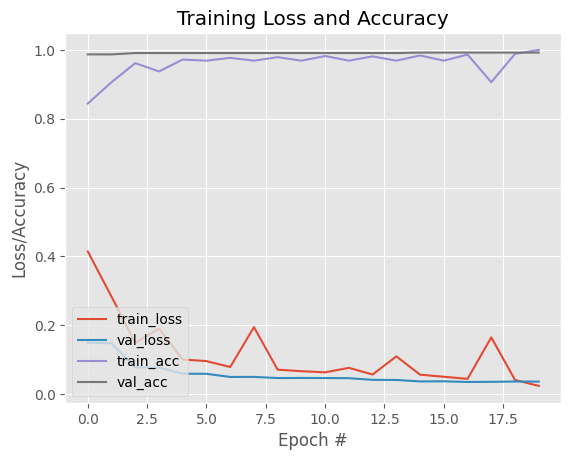

In [10]:
# save the model
#print("[INFO] saving mask detector model...")
#model.save(model_path)
model_json = model.to_json()
with open("mask_detectorr.json", "w") as json_file:
    json_file.write(model_json)
print("[INFO] Model architecture saved as JSON.")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(plot_path)


In [ ]:
#pip install imutils==0.5.3


In [ ]:
#pip install opencv-python
